In [ ]:
# Import necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix

# Set paths
base_dir = '/content/drive/MyDrive/biotech/Retina_Lab/Image_data'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

# Set parameters
img_width, img_height = 224, 224  # VGG16 expects 224x224 input
batch_size = 32
epochs = 20
learning_rate = 1e-4  # Lower learning rate for fine-tuning

## augment images to make the model scale and rotational invariant

In [ ]:
# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Only rescale for testing data
test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Don't shuffle test data
)

# Get class information
num_classes = len(train_generator.class_indices)
print(f"Number of classes: {num_classes}")
print(f"Class indices: {train_generator.class_indices}")


Found 2205 images belonging to 2 classes.
Found 552 images belonging to 2 classes.
Number of classes: 2
Class indices: {'other': 0, 'pr': 1}


## Load pre-trained VGG16 trained on imagenet
- exclude the final classification layer of the model
- trains only the last four layers (why renvent the wheel)
- Add another layer so it's more suitable for our purpose.

In [ ]:
# Load pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Freeze most of the layers
for layer in base_model.layers[:-4]:  # Freeze all but the last 4 convolutional layers
    layer.trainable = False

# Print layer trainability status
for i, layer in enumerate(base_model.layers):
    print(f"{i}: {layer.name} - Trainable: {layer.trainable}")

# Add custom classification layers
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)  # Add dropout to prevent overfitting
x = Dense(num_classes, activation='softmax')(x)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
0: input_layer - Trainable: False
1: block1_conv1 - Trainable: False
2: block1_conv2 - Trainable: False
3: block1_pool - Trainable: False
4: block2_conv1 - Trainable: False
5: block2_conv2 - Trainable: False
6: block2_pool - Trainable: False
7: block3_conv1 - Trainable: False
8: block3_conv2 - Trainable: False
9: block3_conv3 - Trainable: False
10: block3_pool - Trainable: False
11: block4_conv1 - Trainable: False
12: block4_conv2 - Trainable: False
13: block4_conv3 - Trainable: False
14: block4_pool - Trainable: False
15: block5_conv1 - Trainable: True
16: block5_conv2 - Trainable: True
17: block5_conv3 - Trainable: True
18: block5_pool - Trainable: True


## Create Model and set Callbacks
- Callbacks are to monitor the model training
- ModelCheckpoint specifies the where best model weights are saved
- stop training at best model

In [ ]:
# Create the full model
model = Model(inputs=base_model.input, outputs=x)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Set up callbacks
checkpoint = ModelCheckpoint(
    os.path.join(base_dir, 'best_model.h5'),
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    mode='max',
    verbose=1
)

## Training the Model
- plotting function to visualise loss over time and see if it's overfit

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8498 - loss: 0.3514
Epoch 1: val_accuracy improved from -inf to 0.97794, saving model to /content/drive/MyDrive/biotech/Retina_Lab/Image_data/best_model.h5


68/68 ━━━━━━━━━━━━━━━━━━━━ 614s 9s/step - accuracy: 0.8509 - loss: 0.3491 - val_accuracy: 0.9779 - val_loss: 0.0468
Epoch 2/20
 1/68 ━━━━━━━━━━━━━━━━━━━━ 12s 193ms/step - accuracy: 0.9688 - loss: 0.0876

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy improved from 0.97794 to 0.98162, saving model to /content/drive/MyDrive/biotech/Retina_Lab/Image_data/best_model.h5


68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - accuracy: 0.9688 - loss: 0.0876 - val_accuracy: 0.9816 - val_loss: 0.0439
Epoch 3/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 693ms/step - accuracy: 0.9701 - loss: 0.0976
Epoch 3: val_accuracy improved from 0.98162 to 0.98346, saving model to /content/drive/MyDrive/biotech/Retina_Lab/Image_data/best_model.h5


68/68 ━━━━━━━━━━━━━━━━━━━━ 55s 805ms/step - accuracy: 0.9701 - loss: 0.0976 - val_accuracy: 0.9835 - val_loss: 0.0393
Epoch 4/20
 1/68 ━━━━━━━━━━━━━━━━━━━━ 16s 251ms/step - accuracy: 0.9375 - loss: 0.2015
Epoch 4: val_accuracy improved from 0.98346 to 0.98713, saving model to /content/drive/MyDrive/biotech/Retina_Lab/Image_data/best_model.h5


68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.9375 - loss: 0.2015 - val_accuracy: 0.9871 - val_loss: 0.0289
Epoch 5/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 767ms/step - accuracy: 0.9678 - loss: 0.0935
Epoch 5: val_accuracy did not improve from 0.98713
68/68 ━━━━━━━━━━━━━━━━━━━━ 56s 819ms/step - accuracy: 0.9678 - loss: 0.0934 - val_accuracy: 0.9853 - val_loss: 0.0458
Epoch 6/20
 1/68 ━━━━━━━━━━━━━━━━━━━━ 12s 183ms/step - accuracy: 1.0000 - loss: 0.0445
Epoch 6: val_accuracy did not improve from 0.98713
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - accuracy: 1.0000 - loss: 0.0445 - val_accuracy: 0.9871 - val_loss: 0.0425
Epoch 7/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 685ms/step - accuracy: 0.9736 - loss: 0.0667
Epoch 7: val_accuracy improved from 0.98713 to 0.99265, saving model to /content/drive/MyDrive/biotech/Retina_Lab/Image_data/best_model.h5


68/68 ━━━━━━━━━━━━━━━━━━━━ 80s 837ms/step - accuracy: 0.9736 - loss: 0.0667 - val_accuracy: 0.9926 - val_loss: 0.0222
Epoch 8/20
 1/68 ━━━━━━━━━━━━━━━━━━━━ 17s 259ms/step - accuracy: 0.9688 - loss: 0.0856
Epoch 8: val_accuracy did not improve from 0.99265
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.9688 - loss: 0.0856 - val_accuracy: 0.9871 - val_loss: 0.0261
Epoch 9/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 658ms/step - accuracy: 0.9815 - loss: 0.0529
Epoch 9: val_accuracy did not improve from 0.99265
68/68 ━━━━━━━━━━━━━━━━━━━━ 70s 716ms/step - accuracy: 0.9815 - loss: 0.0530 - val_accuracy: 0.9890 - val_loss: 0.0506
Epoch 10/20
 1/68 ━━━━━━━━━━━━━━━━━━━━ 12s 186ms/step - accuracy: 0.9688 - loss: 0.0621
Epoch 10: val_accuracy did not improve from 0.99265
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.9688 - loss: 0.0621 - val_accuracy: 0.9890 - val_loss: 0.0387
Epoch 11/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 640ms/step - accuracy: 0.9828 - loss: 0.0562
Epoch 11: val_accuracy did not

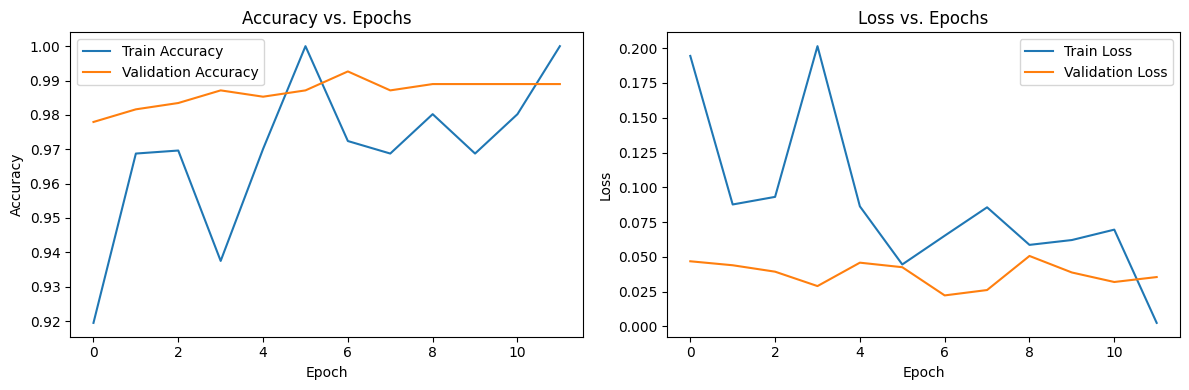

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    callbacks=[checkpoint, early_stopping]
)

# Plot training history
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()
